# Predictive Model for Banking Marketing Campaign
**Objective:** Predict whether a client will subscribe to a term deposit based on client and campaign attributes.


# 1. Hypotheses
 Based on the dataset, here are some hypotheses to validate:
 
 1. Clients with higher balances and no credit defaults are more likely to subscribe.
 2. The success of a campaign is influenced by the duration of contact (`duration`).
 3. Past campaign success (`poutcome`) positively correlates with current subscription rates.
 4. Certain demographic groups (e.g., `job`, `education`) exhibit higher subscription rates.
 5. Clients contacted multiple times during a campaign (`campaign`) may be more likely to subscribe.

## 2. Key Questions

 Here are the questions we aim to address:
 
 1. What are the most important factors influencing client subscription?
 2. How does `duration` of contact impact the likelihood of subscription?
 3. Does the outcome of previous campaigns (`poutcome`) predict success in the current campaign?
 4. Are there significant differences in subscription rates across job types, education levels, and marital statuses?
 5. How do features related to campaign interactions (`pdays`, `campaign`, `previous`) influence subscription?


## 3. Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.utils import resample

## 4. Load Data

In [2]:
# Load the dataset
data = pd.read_csv("data/bank-full.csv", sep=";")
print("Data Shape:", data.shape)
data.head()

Data Shape: (45211, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


## 5. Exploratory Data Analysis (EDA)

In [3]:
# Summary statistics
data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


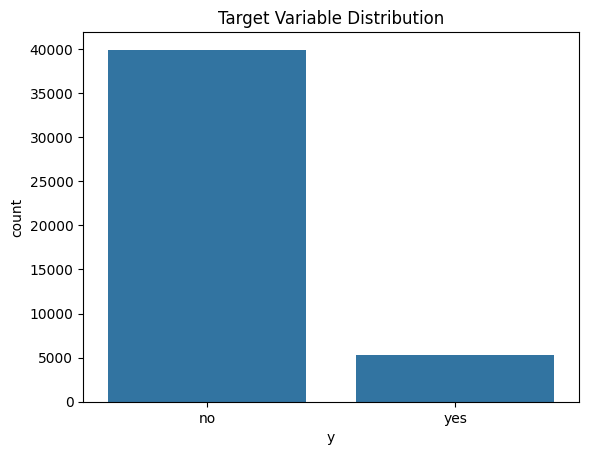

In [4]:
# Question 1: What are the most important factors influencing client subscription?
# Analyze the distribution of the target variable
sns.countplot(x='y', data=data)
plt.title("Target Variable Distribution")
plt.show()

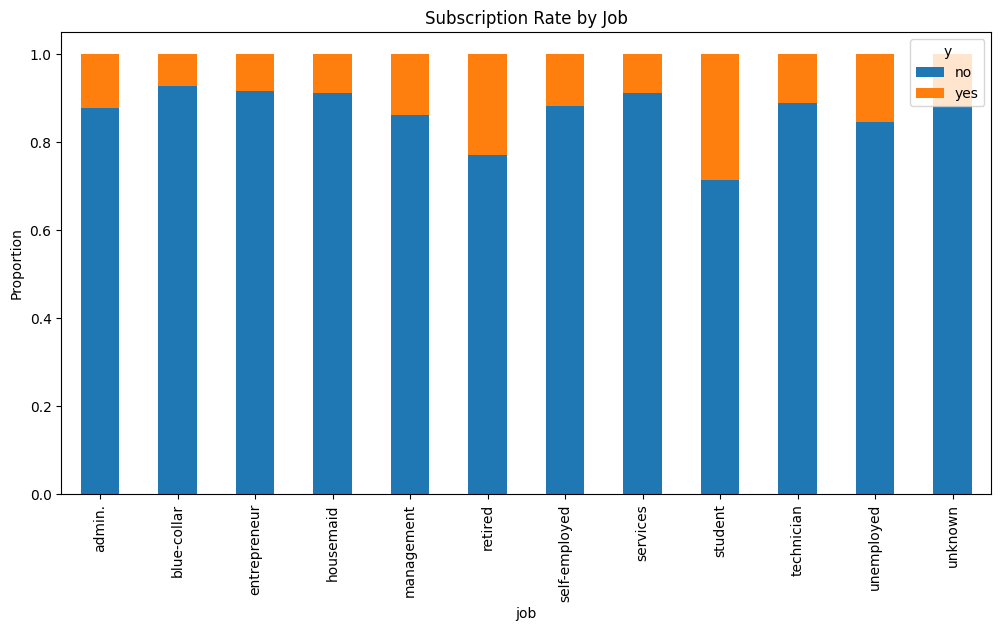

In [5]:
# Question 4: Are there significant differences in subscription rates across job types?
# Analyze subscription rates by job
job_analysis = data.groupby('job')['y'].value_counts(normalize=True).unstack()
job_analysis.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title("Subscription Rate by Job")
plt.ylabel("Proportion")
plt.show()

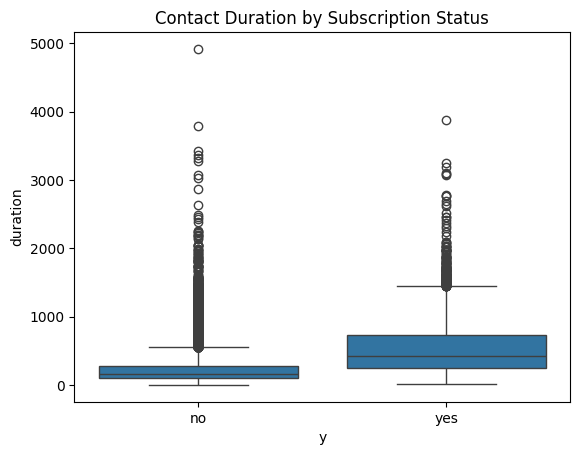

In [6]:
# Question 2: How does `duration` of contact impact the likelihood of subscription?
sns.boxplot(x='y', y='duration', data=data)
plt.title("Contact Duration by Subscription Status")
plt.show()

## 6. Preprocessing

In [7]:
# Identify categorical and numerical columns
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
numerical_features = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']

In [8]:
# Split into train and test
X = data.drop('y', axis=1)
y = data['y'].map({'yes': 1, 'no': 0})  # Encode target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
# Preprocessing pipeline
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

 ## 7. Modeling

Random Forest Classifier

In [10]:
# Define the pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Train the model
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'balance', 'duration',
                                                   'campaign', 'pdays',
                                                   'previous']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'poutcome'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [11]:
# Question 1: What are the most important factors influencing client subscription?
# Get feature importances from the Random Forest model
feature_names = numerical_features + list(model_pipeline.named_steps['preprocessor']
                                          .transformers_[1][1]
                                          .named_steps['onehot']
                                          .get_feature_names_out(categorical_features))

feature_importances = model_pipeline.named_steps['classifier'].feature_importances_
important_features = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
important_features.sort_values(by='Importance', ascending=False, inplace=True)
print(important_features.head(10))

             Feature  Importance
2           duration    0.283085
1            balance    0.110884
0                age    0.105208
48  poutcome_success    0.048121
3           campaign    0.044201
4              pdays    0.041495
5           previous    0.022306
34         month_apr    0.014259
27        housing_no    0.013581
41         month_mar    0.012889


In [12]:
# Predictions and evaluation
y_pred = model_pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95      7952
           1       0.65      0.41      0.50      1091

    accuracy                           0.90      9043
   macro avg       0.79      0.69      0.72      9043
weighted avg       0.89      0.90      0.89      9043



In [13]:
# ROC-AUC Score
y_prob = model_pipeline.predict_proba(X_test)[:, 1]
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))


ROC-AUC Score: 0.9182808238062656


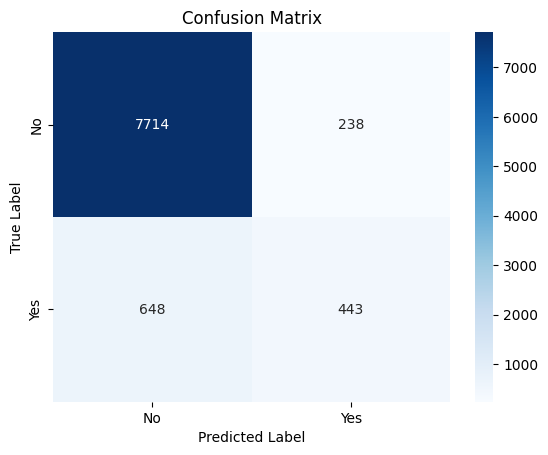

In [14]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

Logistic Regression

In [15]:
# Define the pipeline
log_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Train the model
log_model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'balance', 'duration',
                                                   'campaign', 'pdays',
                                                   'previous']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'poutcome'])])),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

In [16]:
# Predictions and evaluation
y_pred = log_model_pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.98      0.94      7952
           1       0.66      0.35      0.45      1091

    accuracy                           0.90      9043
   macro avg       0.79      0.66      0.70      9043
weighted avg       0.88      0.90      0.89      9043



In [17]:
# ROC-AUC Score
y_prob = log_model_pipeline.predict_proba(X_test)[:, 1]
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))


ROC-AUC Score: 0.9045745601012123


SVC


In [ ]:

# Define the pipeline
svc_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='poly', degree=3, probability=True, random_state=42))
])

# Train the model
svc_model_pipeline.fit(X_train, y_train)

In [ ]:
# Predictions and evaluation
y_pred = svc_model_pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      7952
           1       0.68      0.34      0.45      1091

    accuracy                           0.90      9043
   macro avg       0.80      0.66      0.70      9043
weighted avg       0.89      0.90      0.89      9043



In [ ]:
# ROC-AUC Score
y_prob = svc_model_pipeline.predict_proba(X_test)[:, 1]
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))

ROC-AUC Score: 0.8903867752804638


Random Forest

In [ ]:
# Define the pipeline
dt_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Train the model
dt_model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'balance', 'duration',
                                                   'campaign', 'pdays',
                                                   'previous']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'poutcome'])])),
                ('classifier', DecisionTreeClassifier(random_state=42))])

In [ ]:
# Predictions and evaluation
y_pred = dt_model_pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.93      0.93      7952
           1       0.46      0.45      0.45      1091

    accuracy                           0.87      9043
   macro avg       0.69      0.69      0.69      9043
weighted avg       0.87      0.87      0.87      9043



In [ ]:
# ROC-AUC Score
y_prob = dt_model_pipeline.predict_proba(X_test)[:, 1]
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))

ROC-AUC Score: 0.6886351334404226


## 8. Hyperparameter Tuning

In [ ]:
# GridSearchCV for Random Forest
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

KeyboardInterrupt: 

In [ ]:
# Evaluate tuned model
best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)
print("Tuned Model Performance:")
print(classification_report(y_test, y_pred_tuned))
print("Tuned ROC-AUC Score:", roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1]))

Tuned Model Performance:
              precision    recall  f1-score   support

           0       0.92      0.97      0.95      7952
           1       0.68      0.39      0.49      1091

    accuracy                           0.90      9043
   macro avg       0.80      0.68      0.72      9043
weighted avg       0.89      0.90      0.89      9043

Tuned ROC-AUC Score: 0.9234096144234795


## 9. Save Model and Deployment

In [ ]:
# Save the model
file_path="model/bank_term_deposit_model.pkl"
joblib.dump(best_model, file_path)
print("Model saved!")



Model saved!


In [ ]:
# Simple example of loading and using the model
loaded_model = joblib.load("model/bank_term_deposit_model.pkl")
sample_data = X_test.iloc[0:1]
print("Sample Prediction:", loaded_model.predict(sample_data))

Sample Prediction: [0]
